# How To Guide: How to Add a Damage Sector to MimiGIVE

There are numerous ways to explore and modify the MimiGIVE model. This guide provides suggested workflow for a subset of such modifications, namely those that do not directly modify the MimiGIVE base package itself. Projects with goals that require doing so will have a different advised workflow, using Julia package development workflows. Feel free to post questions to the [Mimi forum](https://forum.mimiframework.org) for advice and documentation references on these from Mimi users and the package developers. Developers also monitor the MimiGIVE [Issues](https://github.com/rffscghg/MimiGIVE.jl/issues) for questions/suggestions.

The **Setup** section below is generic to any new Projects that do not modify the MimiGIVE model source code, as mentioned above. The next sections are specific to the task of adding a new sectoral damages component to the model, but can be used as a template for a variety of other modifications.

This guide does **not** serve as a substitute for or duplicate of the available [Mimi documentation](https://www.mimiframework.org/Mimi.jl/stable/) but instead complements it and may frequently reference Mimi vocabulary and documentation. For example, [Tutorial 3: Modifying an Existing Model](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_3/) may be particuarly helpful.

Finally, in this notebook we save plots to the *outputs* folder and then reload them to display in order to reduce file size of this notebook. This extra step is not necessary for general use, you may simply display your plot ie. `df |> @vlplot(...)` or `Mimi.plot(...)`.

## Software

This guide assumes you have downloaded Julia (we recommend using [juliaup](https://github.com/JuliaLang/juliaup) to do so) and are using Github.

## File Structure

**After this tutorial your repository will more or less mirror this structure, such that *HowToGuide_AddNewSector/* becomes *YourRepositoryName/*. We do not recommend cloning this repository but starting the following steps from scratch in your new repository, copying in files only as necessary or desired.**

All files pertaining to this guide reside in *MimiGIVE/docs/HowToGuide_AddNewSector*.  The *Manifest.toml* and *Project.toml* files define the environment, as described in the **Setup** section. The *src* subfolder holds all source code.

## Setup

First, you will need to set up a Julia Project for your work. Start with a new Github repository, we will use the `HowToGuide_AddNewSector` folder enclosing this guide as the template for that folder.  **Instead of `HowToGuide_AddNewSector`, you will carry out these steps from `YourRepositoryName` folder.** After starting Julia, make the repository folder your current directory and then enter the `Pkg` REPL by typing the `]` key, or alternatively do so using the `Pkg` package as we do below.  Next, activate a new Julia environment, tracked by the `Manifest.toml` and `Project.toml` files (these will appear after you run `add` below), in the current folder.

In [1]:
# These steps simply cd this notebook's code to the folder the guide is in, you 
# can likely skip this step, just make sure your current directory is the top level
# of the repository you are working in.

# @__DIR__ is a macro that copies the full path name of the current file
println("We will cd to $(@__DIR__)")
cd(joinpath(@__DIR__)) 

using Pkg
Pkg.activate(".") # activates the environment in the current directory
Pkg.instantiate(); # only needs to be done once per machine

We will cd to /Users/lisarennels/.julia/dev/MimiGIVE/docs/HowToGuide_AddNewSector


  Activating project at `~/.julia/dev/MimiGIVE/docs/HowToGuide_AddNewSector`


Next add `MimiGIVE` to the environment, as well as the `Mimi` package. You will likely also want to add other packages you need as you go along, as we with the additional packages. **You only need to run the next cell once per project repository**, the packages and their versions will be added and tracked, defining your environment via the `Manifest.toml` and `Project.toml` files, though you'll need to keep them updated with commands like `up` as detailed in [Julia documentation on version control and packages](https://pkgdocs.julialang.org/v1/managing-packages/).  Again you can use `]` to open the `Pkg` REPL in your terminal.

In [ ]:
# ony need to run once
Pkg.add("MimiGIVE")
Pkg.add("Mimi")
Pkg.add("DataFrames")
Pkg.add("Query")
Pkg.add("VegaLite")
Pkg.add("Distributions")
Pkg.add("CSVFiles")
Pkg.add("FileIO")
Pkg.add("Dates");

You can check the status of your current environment using the `status()` function:

In [3]:
Pkg.status()

Status `~/.julia/dev/MimiGIVE/docs/HowToGuide_AddNewSector/Project.toml`
  [5d742f6a] CSVFiles v1.0.2
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.110
  [5789e2e9] FileIO v1.16.3
  [e4e893b0] Mimi v1.5.3
  [08b927d4] MimiGIVE v2.1.0
  [1a8c2f83] Query v1.0.0
  [112f6efa] VegaLite v3.3.0
  [ade2ca70] Dates


The rest of the folder structure is up to you, we will use the customary format of a `src` folder for all source code and a `data` folder for exogenous inputs etc.

## Introduction to Scripts

The following sections will describe the steps to add a damage sector to the model. More specifically,

1. Adding Damage Sector to The Model and Computing the (non-equity weighted) SCC: This section describes how to add a new damage sector, run the model, and compute the SCC. It does *not* include the instructions for adding uncertainty, modifying the intermediate outputs of `compute_scc`, or enabling equity-weighting calculations.

2. Uncertainty: This section describes how to add uncertainty to your damage sector.

3. Modifying SCC Computation for Intermediate Outputs and Equity Weighting: This section describes the additional steps needed to allow for use of intermediate outputs from the `compute_scc` function as well as enabling equity weighting calculations.

Some of these tasks, especially the second and third, **require** a user to study and understand the helper functions within MimiGIVE, and are fairly manual.  Users should feel free to examine the implementations in *MimiGIVE/src/main_mcs.jl* and *MimiGIVE/src/scc.jl* and carry out their own steps instead of following those in Sections II and III ... which are just one example of how this can be accomplished. As mentioned above, any actions that include copy-paste-modify workflows instead of calls like `MimiGIVE.get_mcs` unlink from the current MimiGIVE repository, so any changes made there will need to be manually updated, as opposed to expecting updating your environment with `up` to bring changes in.

**Feel free to post a Github Issue with any questions or for clarification, these guides are meant to evolve with user needs.**

## I. Adding Damage Sector to The Model and Computing the (non-equity weighted) SCC

This section will add a new damage sector to the model such that one can compute the (non-equity weighted) SCC, both deterministically and in Monte Carlo Simulation mode.  The consolidated script can also be found in *HowToGuide_AddNewSector/src/main_model.jl*, which wraps this functionality into a single new function `get_modified_model`, which mirrors `MimiGIVE.get_model`.

By the end of this section the addition of the new damage sector **will** be reflected in a default call to `compute_scc` with an `n > 1` ie. a Monte Carlo Simulation mode, you may wish to (1) add uncertainty to your new damage function (2) use various intermediate output keyword arguments or (3) run equity weighting. **In these cases please see sections II and III.**

### Step 1. Add Component(s) to the Model

In this section, we add a new sectoral damage function to the MimiGIVE model. This is defined in a single Mimi `Component`, although one could use several linked together to carry out a more complex damage function, unit conversions, etc.

First, use the [Mimi documentation](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_4/) as a guide to create your new component(s).  In this case, we have created component `NewSectorDamages` shown in `new_sector_damages.jl`. This component is a dummy with no logical form or results, and is meant as an illustrative example only. Load that component along with the MimiGIVE and `Mimi` packages as follows:

In [ ]:
using Mimi
using MimiGIVE

include("src/new_sector_damages.jl");

Next we will obtain a Model `m` as defined by MimiGIVE, and then add our new component. The `first` argument shows that our component will start in 2020, as do all damages in MimiGIVE, and it will be added to the model `after` the `energy_damages` component. The order here does matter, as `Variable`s output from components flow into others as `Parameter`s.  For example, our `NewSectorDamages` component needs to come *after* the `temperature` component, but *before* the `DamageAggregator` component.

In [5]:
m = MimiGIVE.get_model()
add_comp!(m, NewSectorDamages, first = 2020, after = :energy_damages);

Next we connect the relevant parameters from the socioeconomic and temperature components of MimiGIVE to the relevant inputs of our new component.

In [6]:
connect_param!(m, :NewSectorDamages => :temperature, :temperature => :T)
connect_param!(m, :NewSectorDamages => :gdp, :Socioeconomic => :gdp)

You have now added your new component to the model!  You may go ahead and run the model and look at your outputs below, **however** you will see that its results are _not_ yet added to the aggregated damages, and thus not incorporated into the SCC. We fix these links in the next section and then further explore the results in graphical and tabular form.

In [7]:
run(m)

Build in `Mimi` functions like `explore` and `plot` allow interactive UI exploration and creation of a static plot.  The `explore` function is not biult for the notebook interface and will oepn an external GUI, but try it yourself locally! 

In [ ]:
explore(m) # opens an externtal GUI window

### Step 2. Add Damages to the Damage Aggregator

The MimiGIVE model uses the `DamageAggregator` component to aggregate damages, and these outputs will be used to calculate the Social Cost of Carbon (SCC) via functions such as `compute_scc`. In this section, we will be using the `Mimi.replace!` function to replace the `DamageAggregator` component with a modified one that includes our new sectoral damages. Similarly, we will be replacing the `Damages_RegionAggregatorSum` component, a precursor to the `DamageAggregator` that aggregates all damages to the FUND region level, necessary for some equity-weighting options in `compute_scc`.

In the *DamageAggregator_NewSectorDamages.jl* and *Damages_RegionAggregatorSum_NewSectorDamages.jl* files we have

1. copied *DamageAggregator.jl* and *Damages_RegionAggregaorSum.jl* respectively from the MimiGIVE repository,
2. renamed the components (see `@begin compname`),
3. and added lines to include our new sectoral damages. 

Take a moment to compare the files and see the modifications that were made. Using a search on keyword argument "new_sector" should point you to the important lines.

Note our code here becomes static, unlinked to the template files, such that if MimiGIVE's version updates, you'll need to update your own by hand to stay in step. First we will load that new component:

In [9]:
include("src/DamageAggregator_NewSectorDamages.jl")
include("src/Damages_RegionAggregatorSum_NewSectorDamages.jl");

Next we will replace the original `DamageAggregator` and `Damages_RegionAggregatorSum` components with the new, augmented ones using the `Mimi.replace!` function. Note this function by default will assume to find similar structure and connections, and thus will maintain connections to other components (via the `reconnect` argument which defaults to `true`). The `replace!` function will reset the time dimension of the `DamageAggregator` and `Damages_RegionAggregatorSum` components so you also need reset these component to start in 2020 with `Mimi.set_first_last!` as follows:

In [10]:
replace!(m, :Damages_RegionAggregatorSum => Damages_RegionAggregatorSum_NewSectorDamages)
replace!(m, :DamageAggregator => DamageAggregator_NewSectorDamages)

# both components need to start in 2020, this is reset to the model start (1765) by replace!, so we need to reset it to 2020
Mimi.set_first_last!(m, :DamageAggregator, first=2020)
Mimi.set_first_last!(m, :Damages_RegionAggregatorSum, first=2020);

Finally connect the new sectoral damages component to the new damage aggregator.

In [11]:
connect_param!(m, :DamageAggregator => :damage_new_sector, :NewSectorDamages => :damages)

And the new regional summation aggregator to the new sectoral damages component and the new damage aggregator.

In [12]:
connect_param!(m, :Damages_RegionAggregatorSum => :damage_new_sector, :NewSectorDamages => :damages)
connect_param!(m, :DamageAggregator => :damage_new_sector_regions, :Damages_RegionAggregatorSum => :damage_new_sector_regions)

You can now run your model!

In [13]:
run(m)

Build in `Mimi` functions like `explore` and `plot` allow interactive UI exploration and creation of a static plot.  The `explore` function is not biult for the notebook interface and will oepn an external GUI, but try it yourself locally! 

In [14]:
explore(m)

Electron.Window(Application(Base.PipeEndpoint(RawFD(23) paused, 0 bytes waiting), Process(setenv(`/Users/lisarennels/.julia/artifacts/28d75c9551b709f4f8172bf33e631b433c6c68d6/Julia.app/Contents/MacOS/Julia /Users/lisarennels/.julia/packages/Electron/LXyZ0/src/main.js /var/folders/b3/jd1z51v56jg1d4_fgs7zxsg40000gn/T/jlel-b1c495dc600f11ef287de9efd15d6fc9 /var/folders/b3/jd1z51v56jg1d4_fgs7zxsg40000gn/T/jlel-sn-b1c4c036600f11ef0d56ebf3e8e6f2e8 bxPqxRF5QErrjs4P3nIV8Kbr+QRVG5R17GOYffS7V7WL9foCTGv1uaKsArxP1ssIiPNtPCiMFKA2ZqMwIV1R3DhcwvS/dQSRQgFu+bOGKkvl1YDgmd8Zv0dAtrB1ZENASAjVMXvO9a5yTp6Nkp0WS8Ihvr3QP1npSyz+lR7suKI=`,["XPC_FLAGS=0x0", "PATH=/Users/lisarennels/opt/anaconda3/bin:/Users/lisarennels/opt/anaconda3/condabin:/Users/lisarennels/.juliaup/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/

WARN Symbol legend count exceeds limit, filtering items.


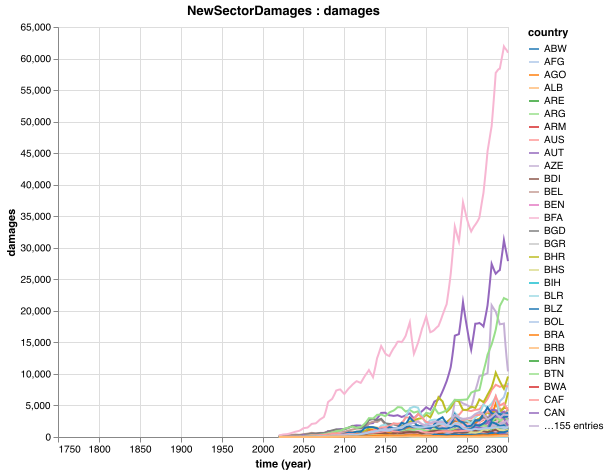

In [15]:
figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)
Mimi.plot(m, :NewSectorDamages, :damages) |> save(joinpath(figure_dir, "NewSector_Damages_v1.png"));
display("image/png", read(joinpath(figure_dir, "NewSector_Damages_v1.png")))

Or look at the data in a tabular format and optionally plot it yourself:

In [16]:
using DataFrames
using Query

df = getdataframe(m, :NewSectorDamages, :damages) |> @filter(_.time >= 2020) |> DataFrame

Row,time,country,damages
,Int64,String,Float64?
1,2020,ABW,0.0377476
2,2020,AFG,0.558741
3,2020,AGO,1.12083
4,2020,ALB,0.258472
5,2020,ARE,4.22053
6,2020,ARG,9.85914
7,2020,ARM,0.325231
8,2020,AUS,16.2582
9,2020,AUT,5.13239


WARN Symbol legend count exceeds limit, filtering items.


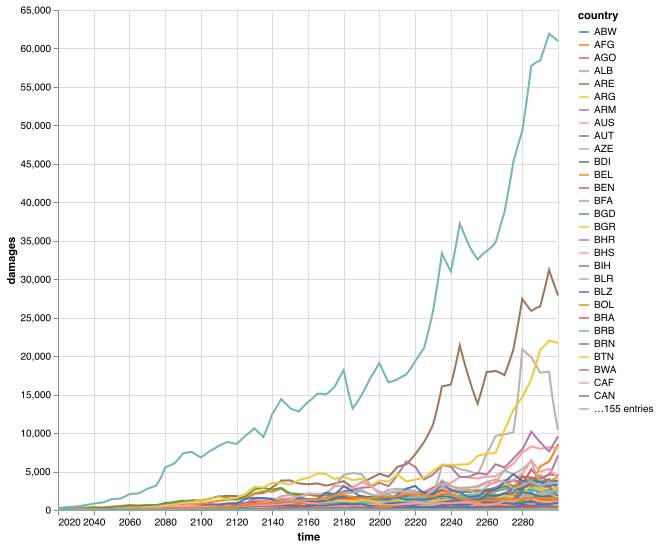

In [17]:
using VegaLite

figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

df.time = string.(df.time) # convert column to String for plotting
df |> @vlplot(:line, x = "time:t", y = :damages, color = :country, width = 500, height = 500) |> save(joinpath(figure_dir, "NewSector_Damages_v2.png"))
display("image/png", read(joinpath(figure_dir, "NewSector_Damages_v2.png")))

In [18]:
# Compare a determinstic run of the SCC (note in practice MimiGIVE should always be run in Monte Carlo Simulation mode, as the deterministic default is not considered a central value)
println("-- Comparing the SCC results of a deterministic run of the modified model to original GIVE -- \n")

my_scc = MimiGIVE.compute_scc(m, year = 2020)
println("My new SCC is $(my_scc) \n")

m_give = MimiGIVE.get_model()
give_scc = MimiGIVE.compute_scc(m_give, year = 2020)
println("GIVE SCC is $(give_scc) \n")

-- Comparing the SCC results of a deterministic run of the modified model to original GIVE -- 

My new SCC is 88.71891404432918 

GIVE SCC is 26.166523151471516 



In [19]:
# Compare a Monte Carlo run with n = 5
println("-- Comparing the SCC results of a Monte Carlo Simulation (n = 5) run of the modified model to original GIVE --\n")

my_scc_mcs = MimiGIVE.compute_scc(m, year = 2020, n = 5, discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45, ew = nothing, ew_norm_region = nothing)]);
println("My new SCC results are $(my_scc_mcs[:scc][(region = :globe, sector = :total, dr_label = "DICE discount rate", prtp = 0.015, eta = 1.45, ew = nothing, ew_norm_region = nothing)])")

give_scc_mcs = MimiGIVE.compute_scc(m_give, year = 2020, n = 5, discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45, ew = nothing, ew_norm_region = nothing)]);
println("GIVE SCC results are $(give_scc_mcs[:scc][(region = :globe, sector = :total, dr_label = "DICE discount rate", prtp = 0.015, eta = 1.45, ew = nothing, ew_norm_region = nothing)])")


-- Comparing the SCC results of a Monte Carlo Simulation (n = 5) run of the modified model to original GIVE --



Running 5 trials for 1 scenarios... 100%|████████████████| Time: 0:00:06


My new SCC results are (expected_scc = 67.80229514925944, se_expected_scc = 5.2960549403698, sccs = Union{Missing, Float64}[63.16172896954073, 73.30917875410792, 51.325677074036534, 83.2161132529877, 67.99877769562438])


Running 5 trials for 1 scenarios... 100%|████████████████| Time: 0:00:05


GIVE SCC results are (expected_scc = 75.06701425339156, se_expected_scc = 11.142857216174285, sccs = Union{Missing, Float64}[72.95899152485657, 81.84220499340577, 43.68630546472656, 111.78360971525044, 65.06395956871847])


The work of this section is consolidated into the `get_modified_model` function in *HowToGuide_AddNewSector/src/main_model.jl* which mirrors `MimiGIVE.get_model`.  We will use this function in the following section.

In [20]:
include("src/main_model.jl")
m = get_modified_model();

## II. Uncertainty

Here we discuss how to add uncertainty to your damage function

Some elements of this task, especially Option 2, **require** a user to study and understand the helper functions within MimiGIVE, and are fairly manual.  Users should feel free to examine the implementations in the *MimiGIVE/src* files and carry out their own steps instead of following those below ... which are just one example of how this can be accomplished. As mentioned above, any actions that include copy-paste-modify workflows instead of calls like `MimiGIVE.get_mcs` unlink from the current MimiGIVE repository, so any changes made there will need to be manually updated, as opposed to expecting updating your environment with `up` to bring changes in.

Remember, any helper function not explicitly exported from `MimiGIVE` can be accessed via `MimiGIVE.<function_name>` or imported using `import MimiGIVE: function_name`.

Searching the keywords `new_sector` or `modified` in modified files should help you zero in on where the important changes were made.

When in doubt post an Issue to the Github repo and we'll get back to you when we can!

#### Option 1. Add Random Variables

In this option, we create a function that modifies an existing `mcs` Monte Carlo Simulation Definition and pass this function as a keyword argument to `MimiGIVE.compute_scc`. This is the simplest approach to adding uncertainty, allowing the use of a keyword argument `post_mcs_creation_function` in `MimiGIVE.compute_scc` without modifying any other files. It lends less flexibility that the more verbose approach, which may be preferable if you already plan to modify `compute_scc` and other intermediate files, but can be quite helpful in some circumstances.

Load in the `get_modified_model` function we wrote in the previous section:

In [ ]:
include("src/main_model.jl")

In MimiGIVE, the function `MimiGIVE.get_mcs` returns a Monte Carlo Simulation struct of type `Mimi.SimulationDef`.  If we wish to add more random variables to this simulation definition, we can create a function (we will call it `update_mcs!`) and use the `post_mcs_creation_function` keyword argument as follows (it is held in *HowToGuide_AddNewSector/src/mcs.jl*). For details and explanations of Mimi's Monte Carlo Simulation functionality, take a look at the Mimi [Tutorial 5: Monte Carlo Simulations and Sensitivity Analysis Support](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_5/) and [How To Guide 3: Conduct Monte Carlo Simulations and Sensitivity Analysis](https://www.mimiframework.org/Mimi.jl/stable/howto/howto_3/).

In [ ]:
using Distributions

function update_mcs!(mcs)

    # add new sector uncertainty
    rv_name = :rv_new_sector_a
    Mimi.add_RV!(mcs, rv_name, Normal(0.005, 0.005/2)) # add random variable
    Mimi.add_transform!(mcs, :NewSectorDamages, :a, :(=), rv_name) # connect random variable to parameter

end

Now whenever we run an mcs using `compute_scc` or `run_mcs`, we simply use the keyword argument `post_mcs_creation_function` which will modify the `mcs` object in place before running it. For example:

In [23]:
results = MimiGIVE.compute_scc(get_modified_model(); 
                                    year = 2020, 
                                    n = 5, 
                                    discount_rates = [(label = "DICE discount rate", prtp = 0.015, eta = 1.45, ew = nothing, ew_norm_region = nothing)],
                                    post_mcs_creation_function = update_mcs!
                                );

Running 5 trials for 1 scenarios... 100%|████████████████| Time: 0:00:05


Or if we wish to run the `mcs` on its own, we can modify it before using it in other functions like `run`.

In [24]:
mcs = MimiGIVE.get_mcs(5)
update_mcs!(mcs)

#### Option 2. Creating a New Monte Carlo Simulation Definition to Embed In a New `compute_scc`

In this option, we write a function to create a new Monte Carlo Simulation and embed into modified versions of additional helper files, all of which build up into `compute_scc`. This is more manual than the option of using the `post_mcs_creation_function` above, but may offer more flexibility. Either Option 1 or Option 2 can be paired with a modified version of `compute_scc`, so the choice is up to the user.

Load in the `get_modified_model` function we wrote in the previous section:

In [ ]:
include("src/main_model.jl")

In MimiGIVE, the function `MimiGIVE.get_mcs` returns a Monte Carlo Simulation struct of type `Mimi.SimulationDef`.  If we wish to add more random variables to this simulation definition, we can create a new function as follows (and is held in *HowToGuide_AddNewSector/src/mcs.jl*). For simplicity we start wtih `MimiGIVE.get_mcs()`, but this function could copy in that function fully, or modify it in any other way as long as it returns the same Type, `Mimi.SimulationDef`.

For details and explanations of Mimi's Monte Carlo Simulation functionality, take a look at the Mimi [Tutorial 5: Monte Carlo Simulations and Sensitivity Analysis Support](https://www.mimiframework.org/Mimi.jl/stable/tutorials/tutorial_5/) and [How To Guide 3: Conduct Monte Carlo Simulations and Sensitivity Analysis](https://www.mimiframework.org/Mimi.jl/stable/howto/howto_3/).

In [ ]:
using Distributions

function get_modified_mcs(trials; args...)
    mcs = MimiGIVE.get_mcs(trials; args...) # get the original MCS

    # add new sector uncertainty
    rv_name = :rv_new_sector_a
    Mimi.add_RV!(mcs, :rv_new_sector_a, Normal(0.005, 0.005/2)) # add random variable
    Mimi.add_transform!(mcs, :NewSectorDamages, :a, :(=), :rv_new_sector_a) # connect random variable to parameter

    return mcs
end

Next we will add a modified version of MimiGIVE's `run_mcs` function, also copied in *HowToGuide_AddNewSector/src/mcs.jl*. Note that the primary changes to this function are using our moedified functions, `get_modified_model.jl` defined in *main_model.jl*, and `get_modified_mcs`, defined above.

In [ ]:
using Dates

function run_modified_mcs(;trials::Int64 = 10000, 
        output_dir::Union{String, Nothing} = nothing, 
        save_trials::Bool = false,
        fair_parameter_set::Symbol = :random,
        fair_parameter_set_ids::Union{Vector{Int}, Nothing} = nothing,
        rffsp_sampling::Symbol = :random,
        rffsp_sampling_ids::Union{Vector{Int}, Nothing} = nothing,
        m::Mimi.Model = get_modified_model(), # <-- using a different default model
        save_list::Vector = [],
        results_in_memory::Bool = true,
    )

    m = deepcopy(m) # in the case that an `m` was provided, be careful that we don't modify the original

    trials < 2 && error("Must run `run_mcs` function with a `trials` argument greater than 1 due to a Mimi specification about SampleStores.  TO BE FIXED SOON!")

    # Set up output directories
    output_dir = output_dir === nothing ? joinpath(@__DIR__, "../output/mcs/", "MCS $(Dates.format(now(), "yyyy-mm-dd HH-MM-SS")) MC$trials") : output_dir
    isdir("$output_dir/results") || mkpath("$output_dir/results")

    trials_output_filename = save_trials ?  joinpath("$output_dir/trials.csv") : nothing

    socioeconomics_module = MimiGIVE._get_module_name(m, :Socioeconomic)
    if socioeconomics_module == :MimiSSPs
        socioeconomics_source = :SSP
    elseif socioeconomics_module == :MimiRFFSPs
        socioeconomics_source = :RFF
    end

    # Get an instance of the mcs
    mcs = get_modified_mcs(trials; # <-- using a different function to obtain the mcs
        socioeconomics_source = socioeconomics_source, 
        mcs_years = Mimi.time_labels(m), 
        fair_parameter_set = fair_parameter_set, 
        fair_parameter_set_ids = fair_parameter_set_ids,
        rffsp_sampling = rffsp_sampling,
        rffsp_sampling_ids = rffsp_sampling_ids,
        save_list = save_list,
    )

    # run monte carlo trials
    results = run(mcs,
        m, 
        trials; 
        trials_output_filename = trials_output_filename, 
        results_output_dir = "$output_dir/results", 
        results_in_memory = results_in_memory
    )

    return results
end

Now, as long as you have also loaded your `get_modified_model` function from *main_model.jl*, you can run a Monte Carlo Simulation including your new uncertainty! All optional arguments are detailed in the MimiGIVE documentation, below we will save a few intermediate outputs with the `save_list` argument, including the `new_sector_damage` from the `DamageAggregator` component you recently added.

In [28]:
# Run a Monte Carlo Simulation
save_list = [
    (:DamageAggregator, :total_damage),
    (:DamageAggregator, :total_damage_share),
    (:DamageAggregator, :cromar_mortality_damage),
    (:DamageAggregator, :agriculture_damage),
    (:DamageAggregator, :energy_damage),
    (:DamageAggregator, :new_sector_damage),
    (:global_netconsumption, :net_consumption),
    (:global_netconsumption, :net_cpc),
    (:global_netconsumption, :global_gdp),
    (:global_netconsumption, :global_population),
    (:temperature, :T),
    (:glaciers_small_icecaps, :gsic_sea_level) ,
    (:antarctic_icesheet, :ais_sea_level),
    (:greenland_icesheet, :greenland_sea_level),
    (:thermal_expansion, :te_sea_level),
    (:landwater_storage, :lws_sea_level)
]

output_dir = joinpath(@__DIR__, "output", "mcs", "MCS_main_output")
mkpath(output_dir)
results = run_modified_mcs(trials=10, save_list=save_list, output_dir=output_dir);
println() # prevent overflow of notebook text

Running 10 trials for 1 scenarios... 100%|███████████████| Time: 0:00:01


Results can now be examined in the `results` returned to memory graphically (again `explore` does not work well in a notebook interface but try it yourself locally), and the tabular outputs are also stored in the *HowToGuide_AddNewSector/output/mcs* folder. **Importantly, these files can get VERY large for country-specific variables at high `n` values (on the order of GB for `n = 1000`, so we recommend being careful with what you save when running high numbers of trials)**. In most cases you will not want to run `run_modified_mcs` on it's own, but instead wrap it into the SCC calculation as below.

In [ ]:
# with large number of trials performance can slow for this UI
explore(results)

In [30]:
using DataFrames
using Query

df = getdataframe(results, :DamageAggregator, :new_sector_damage) |> @filter(_.time >= 2020) |> DataFrame

Row,time,new_sector_damage,trialnum
,Int64,Float64?,Int64
1,2020,1.32262e12,1
2,2021,1.41401e12,1
3,2022,1.5105e12,1
4,2023,1.612e12,1
5,2024,1.71733e12,1
6,2025,1.82429e12,1
7,2026,1.8954e12,1
8,2027,1.96345e12,1
9,2028,2.03067e12,1


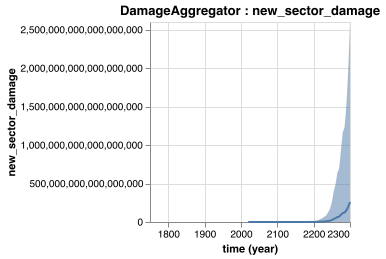

In [31]:
figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

Mimi.plot(results, :DamageAggregator, :new_sector_damage) |> save(joinpath(figure_dir, "NewSector_MCS_Damages.png"))
display("image/png", read(joinpath(figure_dir, "NewSector_MCS_Damages.png")))

## III. Modifying SCC Computation for Intermediate Outputs and Equity Weighting

In some cases a user may want to modify the SCC computation, such as to

1. Incorporate our new damage function into the intermediate outputs of the existing SCC computation function, controlled by various keyword arguments in the `MimiGIVE.compute_scc` function such as `compute_sectoral_values`
2. Allow for running equity weighting.

Here we carry this out by starting from four functions in MimiGIVE's `scc.jl` file, copying them, and modifying them to produce the three functions in *HowToGuide_AddNewSector/src/scc.jl*.  For sake of space we do not copy these below, but please view them in that file. **Searching the keywords `new_sector` or `modified` in these files should help you zero in on where the important changes were made.**


We create four new functions:

- `compute_modified_scc`
- `modified_post_trial_func`
- `_compute_modified_scc`
- `_compute_modified_scc_mcs`

To accomodate the `stream_disaggregatd_damages` keyword argument we use additional modified files found in *HowToGuide_AddNewSector/utils/streaming.jl*.

Remember, any helper function not explicitly exported from `MimiGIVE` can be accessed via `MimiGIVE.<function_name>` or imported using `import MimiGIVE: function_name`.

**Note** once again that this copy and paste method unlinks from current MimiGIVE, and cannot track changes in the original functions. Also, this is again just one approach, users should feel free to write their own new versions of these functions etc. to suit their needs.


After importing those three functions, you will be able to use the `compute_modified_scc` function, along with all of the optional args described in the original `MimiGIVE.compute_scc` function documentation, to produce SCC values and intermediate outputs.

In [32]:
include("src/scc.jl")

output_dir = joinpath(@__DIR__, "output", "scc", "SCC_main_output")
mkpath(output_dir)

results = compute_modified_scc(
                year=2020, 
                n=10, 
                discount_rates = [
                                    (label = "DICE discount rate", prtp = 0.015, eta = 1.45,  ew = nothing, ew_norm_region = nothing),
                                    (label = "2.0%", prtp = exp(0.001972641) - 1, eta = 1.244458999,  ew = nothing, ew_norm_region = nothing)
                                ],
                output_dir=output_dir, 
                save_list=save_list,
                compute_sectoral_values = true,
                save_md = true
            );

Running 10 trials for 1 scenarios... 100%|███████████████| Time: 0:00:11


Note that the `results` returned is a fairly complex data structure, described in the MimiGIVE documentation and accessed within the MimiGIVE paper replication code, but if you have trouble accessing values please open an [Issue](https://github.com/rffscghg/MimiGIVE.jl/issues) to get in touch with the developers!

Also take a look at the output directory in *HowToGuide_AddNewSector*, which holds intermediate results for the `save_list` variables, with the base (no pulse) model as *model_1* and the modified (with pulse) model as *model_2*.  **Importantly, these files can get VERY large for country-specific variables at high `n` values (on the order of GB for `n = 1000`, so we recommend being careful with what you save when running high numbers of trials)**.

In [33]:
using DataFrames
using Query

In [34]:
# Access the computed SCC values

scc_df = DataFrame(:region => [], :sector => [], :discount_rate_label => [], :expected_scc => [], :se_expected_scc => [], :ew => [], :ew_norm_region => [])

results_scc = results[:scc] # results is a dictionary, :scc is a key to this dictionary
for (k,v) in results_scc 
    # results_scc is a dictionary, we iterate over it's keys (k) and values (v)
    # --- the keys are each a NamedTuple with elements region, sector, dr_label, prtp, and eta
    # --- the values are each a Named Tuple with elements expected_scc, se_expected_scc, and sccs (a vector of the sccs)
    append!(scc_df, DataFrame(
                        :region => k.region, 
                        :sector => k.sector,
                        :ew => k.ew,
                        :ew_norm_region => k.ew_norm_region,
                        :discount_rate_label => k.dr_label, 
                        :expected_scc => v[:expected_scc], 
                        :se_expected_scc => v[:se_expected_scc]
                    )
    )
end

sort!(scc_df, [:sector, :region, :discount_rate_label])
scc_df

Row,region,sector,discount_rate_label,expected_scc,se_expected_scc,ew,ew_norm_region
,Any,Any,Any,Any,Any,Any,Any
1,globe,agriculture,2.0%,66.9782,19.5333,,
2,globe,agriculture,DICE discount rate,18.972,5.13233,,
3,globe,cromar_mortality,2.0%,86.639,28.9155,,
4,globe,cromar_mortality,DICE discount rate,23.4091,5.69995,,
5,globe,energy,2.0%,7.76179,2.79592,,
6,globe,energy,DICE discount rate,1.87971,0.442422,,
7,globe,new_sector,2.0%,238.327,105.001,,
8,globe,new_sector,DICE discount rate,53.8946,17.5405,,
9,globe,slr,2.0%,1.36013,0.514,,


In [35]:
# Access the marginal damages (undiscounted)

# marginal damages for the global region for sector new_sector
mds = results[:mds][((region = :globe, sector = :new_sector))]
mds_df = DataFrame(mds, :auto)
rename!(mds_df, Symbol.(2020:2300))
insertcols!(mds_df, 1, :trial => 1:10)
mds_df = stack(mds_df, Not(:trial))
rename!(mds_df, [:trial, :time, :value])

Row,trial,time,value
,Int64,String,Float64
1,1,2020,0.0
2,2,2020,0.0
3,3,2020,0.0
4,4,2020,0.0
5,5,2020,0.0
6,6,2020,0.0
7,7,2020,0.0
8,8,2020,0.0
9,9,2020,0.0


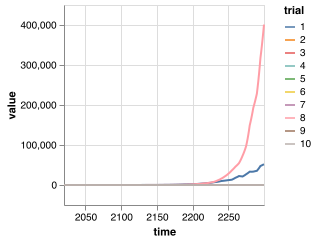

In [36]:
using VegaLite

figure_dir = joinpath(@__DIR__, "output", "figures")
ispath(figure_dir) || mkpath(figure_dir)

mds_df |> @vlplot(:line, x = "time:t", y = :value, color = "trial:n") |> save(joinpath(figure_dir, "NewSector_MCS_MarginalDamages.png"));
display("image/png", read(joinpath(figure_dir, "NewSector_MCS_MarginalDamages.png")))